In [1]:
import sys
import os
import gc
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
import warnings
warnings.simplefilter('ignore')

SEED=2021
def seed_all(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_all(SEED)

c:\Users\Nirajan\Desktop\Fusemachines\Recommendation_System\Sprint-4\Learning to Rank\env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\Nirajan\Desktop\Fusemachines\Recommendation_System\Sprint-4\Learning to Rank\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
anime = pd.read_csv('./data/anime.csv')
rating = pd.read_csv('./data/rating_complete.csv')

In [3]:
print(f"""
anime: shape:{anime.shape}
anime_num: {len(anime.MAL_ID.unique())}
"""
)
anime.head()


anime: shape:(17562, 35)
anime_num: 17562



,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
print(f"""
rating: shape:{rating.shape}
user_num: {len(rating.user_id.unique())}
anime_num: {len(rating.anime_id.unique())}
""")
rating.head()


rating: shape:(57633278, 3)
user_num: 310059
anime_num: 16872



,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [5]:
# rating dataset is large so sample some records.
rating = rating.sample(frac=0.1)
print(f"""
sampled rating
shape:{rating.shape}
user_num: {len(rating.user_id.unique())}
anime_num: {len(rating.anime_id.unique())}
""")


sampled rating
shape:(5763328, 3)
user_num: 285834
anime_num: 15617



In [6]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [7]:
# use anime features
anime_features = ['MAL_ID','English name','Japanese name','Score','Genres','Popularity','Members',
            'Favorites','Watching','Completed','On-Hold','Dropped',
            'Score-1','Score-2','Score-3','Score-4','Score-5',
            'Score-6','Score-7','Score-8','Score-9','Score-10',
           ]
anime = anime[anime_features]

In [8]:
# merge anime and rating
merged_df = anime.merge(rating, left_on='MAL_ID', right_on='anime_id', how='inner')
print(merged_df.shape)
merged_df.head()

(5763328, 25)


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Score-4,Score-5,Score-6,Score-7,Score-8,Score-9,Score-10,user_id,anime_id,rating
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,19180,1,10
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,193024,1,9
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,112160,1,9
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,155191,1,10
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,74372,1,10


In [9]:
del anime
del rating
gc.collect()

1819

### Preprocess

In [10]:
# use genres
genre_names = [
    'Action', 'Adventure','Comedy',
    'Slice of Life','Drama','Sci-Fi',
    'Game','Harem','Military','Space','Music', 'Mecha',
     'Historical', 'Mystery', 'School', 'Hentai', 'Fantasy', 'Horror',
     'Kids', 'Sports', 'Magic', 'Romance', 
]

In [11]:
def genre_to_category(df):
    '''Add genre cagegory column
    '''
    d = {name :[] for name in genre_names}
    
    def f(row):
        genres = row.Genres.split(',')
        for genre in genre_names:
            if genre in genres:
                d[genre].append(1)
            else:
                d[genre].append(0)

    # create genre category dict
    df.apply(f, axis=1)
    
    # add genre category
    genre_df = pd.DataFrame(d, columns=genre_names)
    df = pd.concat([df, genre_df], axis=1)
    return df

In [12]:
def make_anime_feature(df):
    # convert object to a numeric type, replacing Unknown with nan.
    df['Score'] = df['Score'].apply(lambda x: np.nan if x=='Unknown' else float(x)) 
    for i in range(1, 11):
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: np.nan if x=='Unknown' else float(x))
    
    # add genre ctegory columns
    df = genre_to_category(df)
    
    return df

In [13]:
def make_user_feature(df):
    # add user feature
    df['rating_count'] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    return df

In [14]:
def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    merged_df = make_user_feature(merged_df)
    return merged_df

In [15]:
merged_df = preprocess(merged_df)
merged_df.head()

,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,School,Hentai,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,9,7.666667
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,16,7.687500
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,8,7.125000
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,35,7.314286
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,14,8.500000


### Split data

In [16]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)
del merged_df
gc.collect()

0

In [17]:
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (4610662, 49)
test shape:  (1152666, 49)


### Training

In [18]:
features = ['Score', 'Popularity','Members',
            'Favorites','Watching','Completed','On-Hold','Dropped',
            'Score-1','Score-2','Score-3','Score-4','Score-5',
            'Score-6','Score-7','Score-8','Score-9','Score-10',
            'rating_count','rating_mean'
           ]
features += genre_names
user_col = 'user_id'
item_col = 'anime_id'
target_col = 'rating'

In [19]:
train = train.sort_values('user_id').reset_index(drop=True)
test = test.sort_values('user_id').reset_index(drop=True)

In [20]:
# model query data
train_query = train[user_col].value_counts().sort_index()
test_query = test[user_col].value_counts().sort_index()

In [21]:
# try parameter tuning
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1), 
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50), 
    }
     
    #train model
    model = lgb.LGBMRanker(n_estimators=1000, **param, random_state=SEED)
    model.fit(
        train[features],
        train[target_col],
        group=train_query,
        eval_set=[(test[features], test[target_col])],
        eval_group=[list(test_query)],
        eval_at=[1, 3, 5, 10, 20], # calc validation ndcg@1,3,5,10,20
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            ],
    )
    
    # maximize mean ndcg
    scores = []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)
    return np.mean(scores)

In [22]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED) #fix random seed
                           )
study.optimize(objective, n_trials=10)

[I 2024-07-04 10:14:41,621] A new study created in memory with name: no-name-2297384d-2389-4d1e-9686-0e7a01074269


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-07-04 10:17:07,348] Trial 0 finished with value: 0.9015640738277526 and parameters: {'lambda_l1': 0.0007044111641739534, 'lambda_l2': 0.007361306311531573, 'max_depth': 4, 'num_leaves': 161, 'colsample_bytree': 0.9980702969382231, 'min_child_samples': 10}. Best is trial 0 with value: 0.9015640738277526.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-07-04 10:18:43,620] Trial 1 finished with value: 0.9025704017683376 and parameters: {'lambda_l1': 2.703615001882052e-07, 'lambda_l2': 0.010553668055895839, 'max_depth': 9, 'num_leaves': 402, 'colsample_bytree': 0.36782607714740256, 'min_child_samples': 7}. Best is trial 1 with value: 0.9025704017683376.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-07-04 10:21:39,151] Trial 2 finished with value: 0.9014061735408699 and parameters: {'lambda_l1': 0.5002279126949734, 'lambda_l2': 0.0008559719854269106, 'max_depth': 3, 'num_leaves': 288, 'colsample_bytree': 0.7315672960325931, 'min_child_samples': 49}. Best is trial 1 with value: 0.9025704017683376.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-07-04 10:23:36,987] Trial 3 finished with value: 0.9016759702708242 and parameters: {'lambda_l1': 0.0003930378320688003, 'lambda_l2': 9.317229332510368e-06, 'max_depth': 7, 'num_leaves': 105, 'colsample_bytree': 0.6985135826354008, 'min_child_samples': 13}. Best is trial 1 with value: 0.9025704017683376.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-07-04 10:25:11,916] Trial 4 finished with value: 0.9016123774135204 and parameters: {'lambda_l1': 0.0004673391136992949, 'lambda_l2': 6.464095867534913e-05, 'max_depth': 8, 'num_leaves': 422, 'colsample_bytree': 0.8125575188572935, 'min_child_samples': 8}. Best is trial 1 with value: 0.9025704017683376.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds


[I 2024-07-04 10:26:39,571] Trial 5 finished with value: 0.9016892306765703 and parameters: {'lambda_l1': 0.002382492163181986, 'lambda_l2': 0.0014056540581383582, 'max_depth': 11, 'num_leaves': 106, 'colsample_bytree': 0.7322422674017706, 'min_child_samples': 33}. Best is trial 1 with value: 0.9025704017683376.


Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.829273	valid_0's ndcg@3: 0.892477	valid_0's ndcg@5: 0.91615	valid_0's ndcg@10: 0.932921	valid_0's ndcg@20: 0.937626
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-07-04 10:28:49,812] Trial 6 finished with value: 0.9026312870924531 and parameters: {'lambda_l1': 2.5618220897682866e-06, 'lambda_l2': 0.09417262685815364, 'max_depth': 8, 'num_leaves': 503, 'colsample_bytree': 0.6095625634567645, 'min_child_samples': 10}. Best is trial 6 with value: 0.9026312870924531.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's ndcg@1: 0.829005	valid_0's ndcg@3: 0.892289	valid_0's ndcg@5: 0.916033	valid_0's ndcg@10: 0.932812	valid_0's ndcg@20: 0.937526


[I 2024-07-04 10:30:28,157] Trial 7 finished with value: 0.901533206729608 and parameters: {'lambda_l1': 0.00011766497432591422, 'lambda_l2': 2.8463576586210582e-05, 'max_depth': 12, 'num_leaves': 364, 'colsample_bytree': 0.9234587709563493, 'min_child_samples': 32}. Best is trial 6 with value: 0.9026312870924531.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's ndcg@1: 0.829256	valid_0's ndcg@3: 0.892445	valid_0's ndcg@5: 0.916151	valid_0's ndcg@10: 0.932906	valid_0's ndcg@20: 0.937613


[I 2024-07-04 10:31:48,090] Trial 8 finished with value: 0.9016745409880376 and parameters: {'lambda_l1': 0.0012434816947988851, 'lambda_l2': 5.466023520987005e-06, 'max_depth': 11, 'num_leaves': 157, 'colsample_bytree': 0.515280425745991, 'min_child_samples': 14}. Best is trial 6 with value: 0.9026312870924531.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2024-07-04 10:34:55,234] Trial 9 finished with value: 0.9021800192619314 and parameters: {'lambda_l1': 1.3222683079352992e-06, 'lambda_l2': 0.00161209278995891, 'max_depth': 4, 'num_leaves': 200, 'colsample_bytree': 0.753329900451546, 'min_child_samples': 44}. Best is trial 6 with value: 0.9026312870924531.


In [23]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 10
Best trial: {'lambda_l1': 2.5618220897682866e-06, 'lambda_l2': 0.09417262685815364, 'max_depth': 8, 'num_leaves': 503, 'colsample_bytree': 0.6095625634567645, 'min_child_samples': 10}


In [25]:
# train with best params
best_params = study.best_trial.params
model = lgb.LGBMRanker(n_estimators=1000, **best_params, random_state=SEED,)
model.fit(
    train[features],
    train[target_col],
    group=train_query,
    eval_set=[(test[features], test[target_col])],
    eval_group=[list(test_query)],
    eval_at=[1, 3, 5, 10, 20],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        ],
)

[LightGBM] [Warning] lambda_l1 is set=2.5618220897682866e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5618220897682866e-06
[LightGBM] [Warning] lambda_l2 is set=0.09417262685815364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09417262685815364
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=2.5618220897682866e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5618220897682866e-06
[LightGBM] [Warning] lambda_l2 is set=0.09417262685815364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09417262685815364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] lambda_l1 is set=2.5618220897682866e-06, reg_alpha=0.0

LGBMRanker(colsample_bytree=0.6095625634567645,
           lambda_l1=2.5618220897682866e-06, lambda_l2=0.09417262685815364,
           max_depth=8, min_child_samples=10, n_estimators=1000, num_leaves=503,
           random_state=2021)

In [26]:
#　check output　value
model.predict(test.iloc[:10][features])

[LightGBM] [Warning] lambda_l1 is set=2.5618220897682866e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5618220897682866e-06
[LightGBM] [Warning] lambda_l2 is set=0.09417262685815364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09417262685815364


array([-0.48306573,  0.63066431, -0.92306946,  0.20298495,  0.5028322 ,
        0.67981619, -1.5175695 , -0.48016419, -0.09232985, -1.28646242])

Text(0.5, 1.0, 'feature importance')

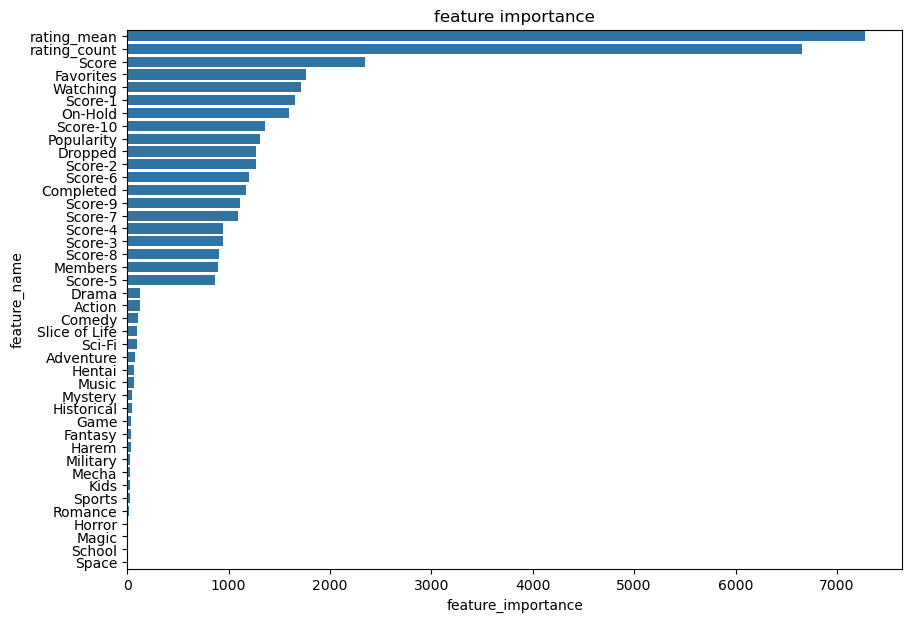

In [27]:
# feature imporance
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

### Recommend for User

In [48]:
def recommend_for_user(user, model, k, sample_anime_num):
    anime = pd.read_csv('./data/anime.csv')
    pred_df = anime.sample(sample_anime_num).reset_index(drop=True) # sample recommend candidates
    rating = pd.read_csv('./data/rating_complete.csv')

    # preprocess for model prediction
    user_df = rating.query('user_id==@user')
    user_df = make_user_feature(user_df)
    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]
    pred_df = make_anime_feature(pred_df)

    # recommend
    preds = model.predict(pred_df[features])    
    topk_idx = np.argsort(preds)[::-1][:k]
    recommend_df = pred_df.loc[topk_idx].reset_index(drop=True)

    # check recommend
    print('---------- Recommend ----------')
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')

    print('\n---------- Actual ----------')
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner')
    for i, row in user_df.sort_values('rating',ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}')    

    return recommend_df

In [49]:
user = 20 # user_id
k = 10 # num of recommend items
sample_anime_num=1000 # num of recommend candidates 
recommend_df = recommend_for_user(user, model, k, sample_anime_num)

[LightGBM] [Warning] lambda_l1 is set=2.5618220897682866e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5618220897682866e-06
[LightGBM] [Warning] lambda_l2 is set=0.09417262685815364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09417262685815364
---------- Recommend ----------
1: ホリミヤ:Horimiya
2: 蟲師:Mushi-Shi
3: 劇場版 空の境界 the Garden of sinners 第七章『殺人考察（後）』:the Garden of sinners Chapter 7:Murder Speculation Part B
4: ヱヴァンゲリヲン新劇場版:破:Evangelion:2.0 You Can (Not) Advance
5: 劇場版 夏目友人帳 ～うつせみに結ぶ～:Natsume Yujin-cho the Movie:Ephemeral Bond
6: Angel Beats!（エンジェルビーツ）:Angel Beats!
7: とらドラ！:Toradora!
8: 坂道のアポロン:Kids on the Slope
9: 終物語:Owarimonogatari
10: マギ The kingdom of magic:Magi:The Kingdom of Magic

---------- Actual ----------
rating:10: デジモンアドベンチャー:Digimon:Digital Monsters
rating:10: デジモンアドベンチャーtri.（トライ）第６章「ぼくらの未来」:Digimon Adventure tri. Future
rating:10: ハイキュー!! セカンドシーズン:Haikyu!! 2nd Season
rating:10: 転生したらスライムだった件:That Time I Got Reincarnated as a Slime
rati